# V6
* 이제 Validation Data, Training Data 모두 가져와서 Training Data의 20%를 Test Data로 떼어놓고
* Training Data로 model을 학습하고 Validation Data를 넣어 값을 확인하며 하이퍼파라미터 값 수정
* Validation Data로 좋은 정확도를 보이는 model을 찾아 Test Data를 넣어 정확도 확인
* 만약 Validation Data에만 최적화된 model이라면 Validation Data에 대해 과적합이니 하이퍼파라미터 값 수정
* 그렇지않고 새로운 데이터인 Test Data에서도 좋은 정확도를 보인다면 일반화된 model이란 것을 의미

# GPU

In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2022-11-05 17:05:53.942553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 17:05:54.602539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4053 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b3:00.0, compute capability: 8.0


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Training 파일 안의 모든 이미지 픽셀수 변경

In [3]:
# 원하는 주소 안에있는 png로 끝나는 파일들 모두 (28,28)로 형태 변환
def fixel(image_path):
    img_list = os.listdir(image_path)
    img_list_jpg = [img for img in img_list if img.endswith(".png")]

    lst = []
    for i in img_list_jpg:
        img = Image.open(image_path + i)
        img = img.resize((28,28))
        img_array = np.array(img)
        lst.append(img_array)
        
    return lst

In [4]:
# Validation Data
Val_L = fixel("Data/Validation/L/")
Val_M = fixel("Data/Validation/M/")
Val_S = fixel("Data/Validation/S/")



# Training Data
Tra_L = fixel("Data/Training/L/")
Tra_M = fixel("Data/Training/M/")
Tra_S = fixel("Data/Training/S/")

# L, M, S 데이터 합치기

In [5]:
# Validation Data
X_val = Val_L + Val_M + Val_S
X_val_np = np.array(X_val)

print("Validation Data Shape :", X_val_np.shape)



# Training Data
X_train = Tra_L + Tra_M + Tra_S
X_train = np.array(X_train)

print("Training Data Shape :", X_train.shape)

Validation Data Shape : (1020, 28, 28, 3)
Training Data Shape : (7140, 28, 28, 3)


In [6]:
# Validation Data
y_val = []

for i in ["L", "M", "S"]:
    for j in range(340):
        y_val.append(i)
        
y_val_np = np.array(y_val)
print("Validation Data Shape :", y_val_np.shape)




# Training Data
y_train = []

for i in ["L", "M", "S"]:
    for j in range(2380):
        y_train.append(i)
        
y_train = np.array(y_train)
print("Validation Data Shape :", y_train.shape)

Validation Data Shape : (1020,)
Validation Data Shape : (7140,)


# y_val_np, y_train 문자열을 정수로 변환

In [7]:
# Validation Data
y_val_np = np.where(y_val_np == "L", 0, y_val_np)
y_val_np = np.where(y_val_np == "M", 1, y_val_np)
y_val_np = np.where(y_val_np == "S", 2, y_val_np)

y_val_np = y_val_np.astype("int")




# Training Data
y_train = np.where(y_train == "L", 0, y_train)
y_train = np.where(y_train == "M", 1, y_train)
y_train = np.where(y_train == "S", 2, y_train)

y_train = y_train.astype("int")

# 데이터 나누기

In [18]:
from sklearn.model_selection import train_test_split


# Validation Data
# X_val_np, y_val_np

# Training Data
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.2, random_state=42)

# Training Data로 model을 학습시키고 Validation Data로 평가
* 정확도가 높게 나오는 모델 구현

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=50)

loss, acc = model.evaluate(X_val_np, y_val_np, verbose=2)

print("오차 :",loss,"정확도 :", acc)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 2, 2, 32)        

# Training Data로 학습시킨 모델을 Validation으로 하이퍼파라미터 값을 조정하고 Test Data에 적용
* Test Data라는 새로운 데이터에대해 97.47%라는 정확도를 보이는 것을 보니 Validation Data에 과적합 된것이 아닌 일반화된 model을 만들었고 새로운 데이터에도 잘 작동된다.

In [26]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50)

loss, acc = model.evaluate(x_test, y_test, verbose=2)

print("오차 :",loss,"정확도 :", acc)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 5, 5, 32)          4640      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 2, 2, 32)        

# 학습 곡선
* 학습 결과가 loss는 낮고 accuracy는 높다는 것을 볼 수 있습니다.

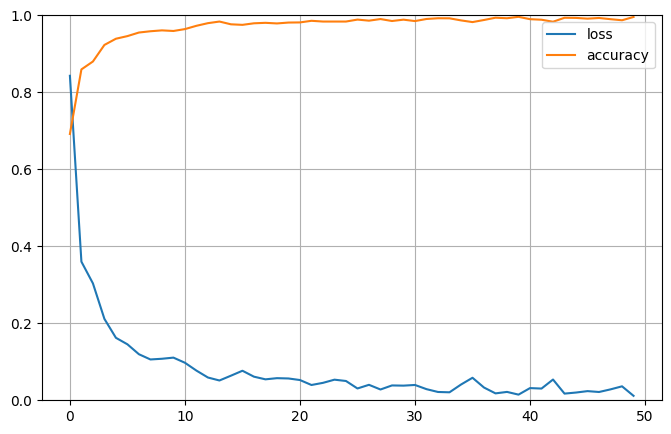

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()